## (B)  Build a minimal generative model and use it to analyze test data

### 1. Import your package in the documentation notebook.

In [1]:
import lennardjones

### 2. Describe your generative model.

#### We will start with just the Lennard Jones model.

The Lennard Jones *potential* has a well known phenominolgical model:

$$ U_\text{LJ} = 4 \epsilon \left ( \frac{\sigma_\text{LJ}^{12}}{z^{12}} - \frac{\sigma_\text{LJ}^6}{z^6} \right ) $$

Where $\epsilon$ is the depth of the well (or 'strength' of the interaction), $\sigma$ is distance when the potential is 0 (or the 'size' of the interacting particles), and $z$ is the distance between the particles.

To compute the force, $F = -\partial U / \partial z$, so 
$$ F_\text{LJ} = 4 \epsilon \left ( \frac{12\sigma_\text{LJ}^{12}}{z^{13}} - \frac{6\sigma_\text{LJ}^6}{z^7} \right ) $$

The goal of the first task is to fit to the above model, using $\epsilon$ and $\sigma$ as parameters. 

However, the measured data is frequency shift (df) and must be first coverted to force. This is done using the Sader-Jarvis method, which takes an intergral over the distance data, starting at the closest $z$ position. 

All parameters in the Sader-Jarvis formula are known experimental parameters. 

#### Sader-Jarvis method to convert to force

$$ F_\text{meas} = 2k \int_z^\inf \left ( 1 +  \frac{a^{1/2}}{8 \sqrt{\pi(t-z)}} \right ) d\Omega(t) - \frac{a^{3/2}}{\sqrt{2(t-z)}} \frac{d \Omega(t)}{dt} dt $$

where $k$ is the spring constant of the tuning fork, $a$ is the oscillation amplitude, $\Omega(z) = d\omega(z)/ \omega_0 = d\text{f}(z)/\text{f}_0$, and $t$ is the integration variable.

$k$ and $a$ are experiemental details that are known.


#### Experimental considerations

The raw data is frequency shift df and position of the piezo $z'$. 

**df**

The frequency shift is the measured data and has noise. Based on traces taken far from the sample, the background noise on this measurement is $\sigma_\text{df} = 0.5$ Hz. 

***z'***

To keep things simple the first time, we will set the position of the sample $z_0$ equal to 1 nm below the lowest $z'$ position. Thus the tip position relative to the sample (i.e. the $z$ in the above equations) becomes $z$ = $z'$ - ($z_\text{min}$ - 1 nm).

$k$ = 1800 N/m

$a$ = 0.5 nm

In all honesty it is quite possible there is a 10 % uncertainty on each of these parameters as well. It may be desirable to include that as a prior and marginalize out the small range.

However, again to keep things simple in this first itteration, we will assume the values above are exact. 

Given all of this, there are *no* parameters in the force calculation and so we should simple be able to perform the calculation; however, the uncertainty needs to also be converted from df to force (i.e. $\sigma_\text{df} \rightarrow \sigma_\text{force}$ )

##### Use the notation we introduced in the course to describe your statistical model, which should include the priors

I'm a little stuck on this because of the Sader-Jarvis conversion on the y-data. After that however, it would be:

**model**

$\mu = 4 \epsilon \left(\frac{12\sigma^{12}}{z^{13}} - \frac{6\sigma^{6}}{z^{7}} \right )$

**priors**

For both of these they cannot be 0 and we started getting limited by the size of atoms. We don't expect these terms to be larger than 1 $\mu$m (notice, all units will be in n-units). 

$\epsilon$ ~ Jeffreys(0.0001,1000) (or on a log scale, log($\epsilon$) ~ uniform(-4,3) )

$\sigma_\text{LJ}$ ~ Jefferys(0.0001,1000) (or on a log scale, log($\sigma$) ~ uniform(-4,3) )

**Add Gaussian noise to the model**

F ~ normal($\mu$ = $\mu$, $\sigma = \sigma_\text{force}$ )

### 3. Simulate some data using your generative model.

start with LJ force model and work backwards

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [3]:
z = np.arange(2.4, 30, 0.2) #nN

In [120]:
noise = 0.02 #nN

In [121]:
def simulate_data(epsilon, sigma, noise, z):
    
    '''
    generates noisy Lennard Jones force data
    
    Inputs:
    -------
    epsilon: float. The depth of the well in the L-J theory
    sigma: float. The distance to 0 potential in the L-J theory
    noise: float or ndarray (of size z) of noise to be added at each point.
    z: ndarray. the range over which the function will generate the data
    
    Returns:
    --------
    data: ndarray (of size z) of the corresponding Lennard Jones force, 
        assuming a normal distribution of the noise
    
    '''
    
    perfect_data = 4*epsilon*(12*sigma**12/z**13 - 6*sigma**6/z**7)
    
    #add some noise
    noisyLJ_data = perfect_data + scipy.stats.norm.rvs(loc=0, scale = noise, size = len(z))
    
    #I know this will create something ~ nN
    return noisyLJ_data

In [122]:
##### epsilon, the depth of the well, which I expect to be ~ nN
eps = 2.6 #nV

#sigma LJ, 'size of particle', ~ 2 nm maybe?
s_lj = 2.4  #nm

Text(0, 0.5, 'force (nN)')

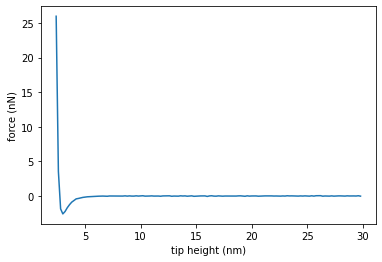

In [123]:
plt.plot(z,simulate_data(eps, s_lj, noise, z))


plt.xlabel('tip height (nm)')
plt.ylabel('force (nN)')

#need to cut the range otherwise you can't see the feature
#plt.ylim([-3,50]);

In [8]:
f_testdata = simulate_data(eps, s_lj, noise, z)

### 4. Infer parameters from your simulated data.

Using pymc3

In [9]:
import pymc3 as pm
import arviz as az
import seaborn as sns

Step 1: define the model

In [10]:
lj_model = pm.Model()

with lj_model:
    
    #Jefferys prior from 0.0001 (10e-4) to 1000 e3
    logepsilon = pm.Uniform('logepsilon', -4, 3, testval = np.log(9))
    logsigma = pm.Uniform('logsigma',-4, 3, testval = np.log(2))
    
    #convert to reg parameters:
    epsilon = pm.Deterministic('epsilon', np.exp(logepsilon))
    sigma = pm.Deterministic('sigma', np.exp(logsigma))
    
    #model
    force = 4*epsilon*(12*sigma**12/z**13 - 6*sigma**6/z**7)
    
    # Likelihood of observations (i.e. noise around model)
    measurements = pm.Normal('F', mu=force, sigma=noise, observed=f_testdata)

Step 2: find the MAP (optional)

But I'm doing it to double check my starting guesses are good

In [11]:
map_estimate = pm.find_MAP(model=lj_model)
map_estimate

{'logepsilon_interval__': array(0.84460625),
 'logsigma_interval__': array(0.8322212),
 'logepsilon': array(0.8960412),
 'logsigma': array(0.87777071),
 'epsilon': array(2.44988529),
 'sigma': array(2.40553109)}

Sample and plot samples:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsigma, logepsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8841674161577359, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


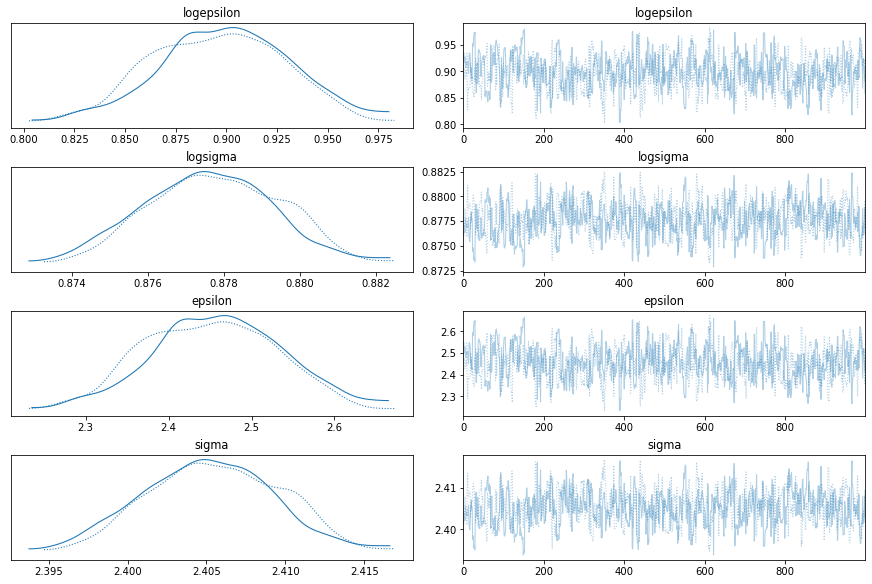

In [12]:
with lj_model:
    trace =pm.sample(1000, start = map_estimate, return_inferencedata=True)
    az.plot_trace(trace);

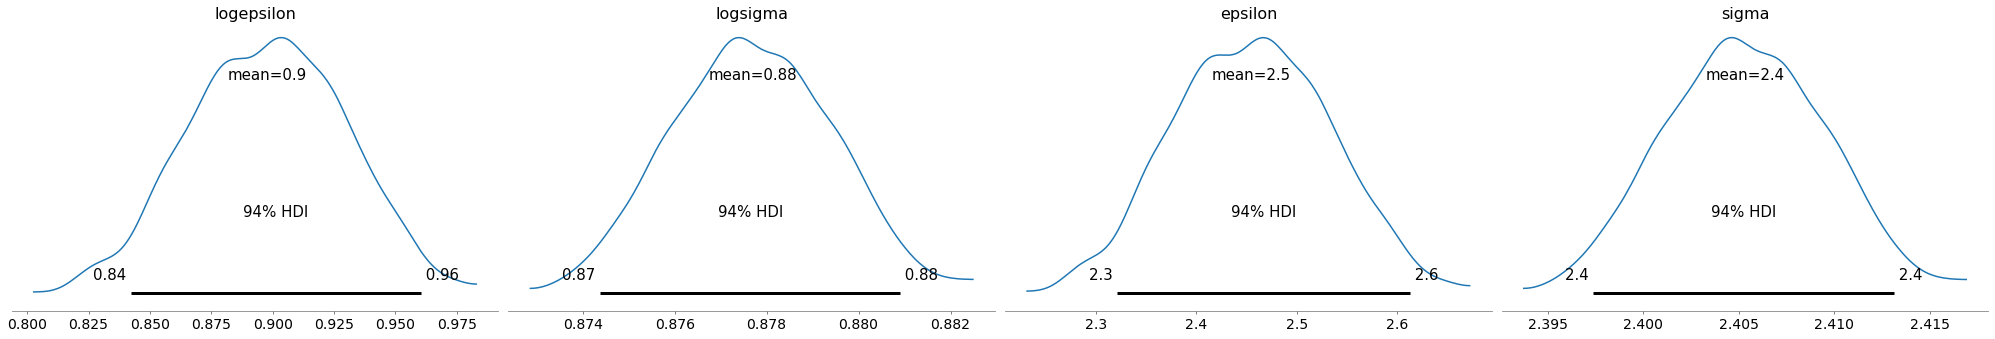

In [13]:
with lj_model:
    az.plot_posterior(trace)

In [14]:
posterior_dataframe = trace.posterior.to_dataframe()

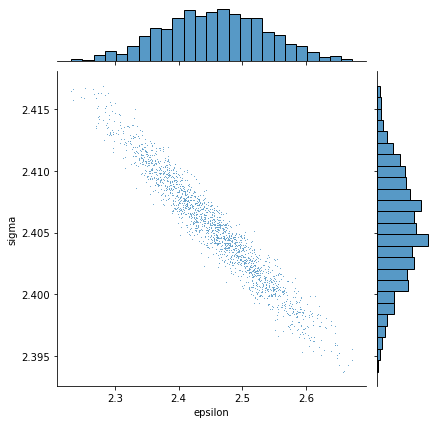

In [15]:
joint_kde = sns.jointplot(x='epsilon', y='sigma', data=posterior_dataframe, kind='scatter', s=1)

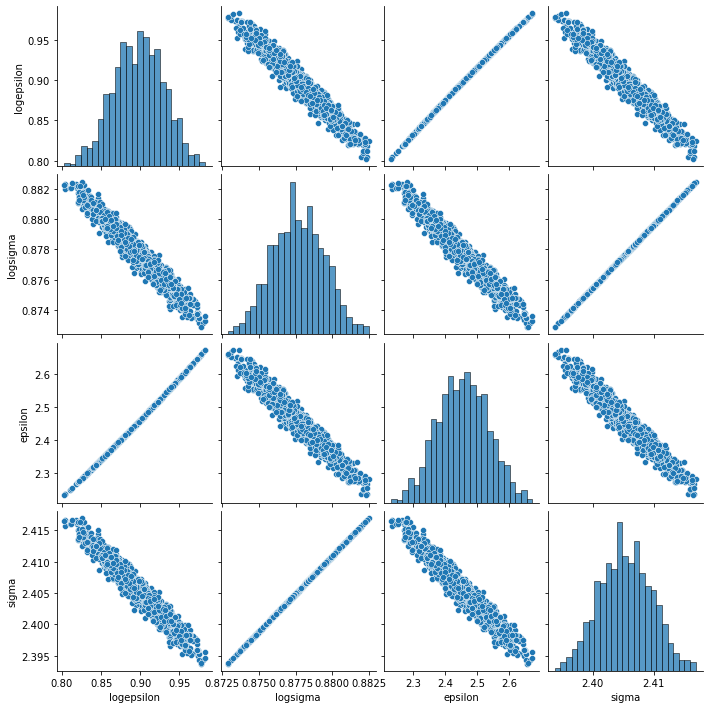

In [16]:
sns.pairplot(posterior_dataframe)

## Converting the peak to peak noise value to a Gaussian variation

The tip picks up on 1 Hz peak to peak noise at a very high frequency. This means we are doing some averaging when we collect data. The oscilloscope collects 100000 points over 10s.

Data are collected in a bias sweep, collecting 801 data points in about 10 s. For the z sweep we only take one of these data points (at a constant bias) for each z position. This means each z-data point is averaged over 0.0125 s.

In [73]:
f_0 = 19796.5 # central frequency f_0, Hz

Let's generate 1s of noise data and average over 0.0125 s.

In [102]:
half_ptp = 0.5 #half peak to peak = 0.5 H
f_sampling = 100000/10

test_time = np.arange(0,1, 1/f_sampling)

test_noise = scipy.stats.norm.rvs(loc=0, scale = half_ptp, size = len(test_time))

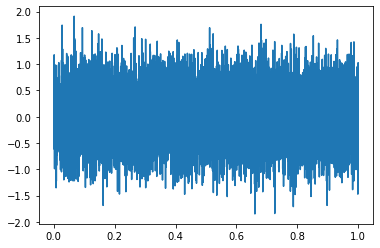

In [103]:
plt.plot(test_time, test_noise)

This looks very similar to the time trace we have for background noise.

In [104]:
len(test_noise)/len(np.arange(0,1,0.0125))

125.0

In the test_noise dataset, if I average over 125 values I'll get the average value for averaging over 0.0125 s.

The easiest way to do this is to *convolve* the noise array with an array of 1s of the lenth I want to take a rolling average of. I use 'valid' so that it starts with the 1-array fully inside the noise array.

In [107]:
average_over = 125
rolling_ave_noise = np.convolve(test_noise, np.ones([average_over]), 'valid')/average_over

In [108]:
np.abs(np.mean(rolling_ave_noise))

0.013220079805787545

I don't know if I fully believe this .. it seems too small.

This value will also change every time (since it's based on randomly sampling the normal distribution, so to keep things simple and easy we'll round up to 0.015 Hz. 

In [110]:
averaged_noise = 0.015

## Converting the error from $\sigma_\text{df}$ to $\sigma_\text{force}$

using the same z, let's trying to generate the df data, then use df+$\sigma_\text{df}$ in the Sader-Jarvis formula, then df-$\sigma_\text{df}$ in the formula to quantify $\sigma_\text{force}$. This will probably make $\sigma$ an array instead of a fixed value.

This is a really bad model (not really based on anything), but it's a good order of magntiude.

In [111]:
def simulate_df(a, b, z):
    
    '''
    This functoin attempts to generate df data. This is tricky since we don't have a closed form theory
    for what this should look like. This model qualitatively matches df data from the Hoffman Lab.
    
    Inputs:
    a: float. a scaling factor
    b: float.  a scaling factor
    z: ndarray where you would like to generate frequency shift data
    
    Returns:
    -------
    perfect_data: ndarray of frequency shift with no noise. 
    '''
    
    z_new= z*10**-9
    perfect_data = 0.3*a**13/(z_new+5*10**-9)**13 - b/z_new**2
    
    return perfect_data/2*10**9

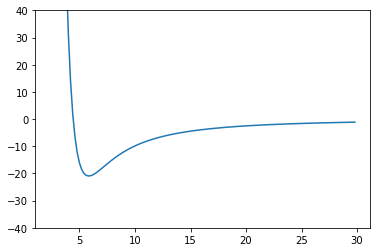

In [112]:
plt.plot(z, simulate_df(3*10**-9, 2*10**-24,z))
#plt.xlim([0, 25]);
plt.ylim([-40, 40]);

Sader-Jarvis code I had already:

In [113]:
a = 0.5*10**-9 #amplitude in meters
k = 1800 # N/m 

In [114]:
def calculate_force(a,k,f_0, z, df_data):
    
    '''
    calculates force from given frequency shift data and corresponding z positions.
    Notice, the absolute value of the force does not depend on the absolute value of the z position,
    just the difference between sequential z positions. Therefore the z input can be the 'piezo' z position;
    it doens't have to be relative to the sample.
    
    Inputs:
    -------
    a: float. amplitude of oscillation in units of m
    k: spring constant of the AFM tip. in untis of N/m
    f_0: reasonant frequency of the AFM tip. in Hz.
    z: ndarray of the height of the tip. It does not need to be height with respect to sample,
        but the differences between heights need to be accurate.
    df_data: frequency shift data at corresponding z positions. In units of Hz. 
    
    Returns:
    --------
    force_array: ndarray (of size z) of the corresponding force, calculated using the method outlined
        by Sader and Jarvis (2004) DOI: 10.1063/1.1667267 Eg (9)
    
    '''
    
    root_amplitude = np.sqrt(a)

    const_2 = root_amplitude / (8*np.sqrt(np.pi)) #units sqrt m
    const_3 = root_amplitude**3 / np.sqrt(2)      #units m * sqrt m

    xdata = z
    ydata = df_data
    
    new_size = len(z) -1

    #creat empty array to store the calculation in
    force_array = np.zeros([new_size])
    
    omega = ydata / f_0
    omegadz = np.gradient(omega) / np.gradient(xdata)

    first_term = np.zeros([new_size])
    second_term = np.zeros([new_size])
    third_term = np.zeros([new_size])
    correction_term = np.zeros([new_size])

    for zi in range(0, new_size):
        t = zi+1
        root_t_z = np.sqrt((xdata[t:] - xdata[zi]))
    
        integral_1 = np.trapz((omega[t:]), x = xdata[t:]) 
        integral_2 = np.trapz(((const_2 / root_t_z) * omega[t:]), x = xdata[t:])     
        integral_3 = np.trapz(- (const_3 / root_t_z * omegadz[t:]), x = xdata[t:])
        
        first_term[zi] = 2 * k * (integral_1)
        second_term[zi] = 2 * k * (integral_2)
        third_term[zi] = np.real(2 * k * (integral_3))
    
        # correction terms for t=z from [2] mathematica notebook SJ
        corr1 = omega[zi] * (xdata[t]-xdata[zi])
        corr2 = 2 * const_2 * omega[zi] * np.sqrt(xdata[t] - xdata[zi])
        corr3 = -2 * const_3 * omegadz[zi] * np.sqrt(xdata[t] - xdata[zi])
        correction_term[zi] = 2 * k * (corr1 + corr2 + corr3)
    
    force_array = first_term+second_term+third_term+correction_term
    
    return force_array

With this working, one thing we can do is *sample from it*. I'm not sure what that will look like, but it will allow us to encorporate the $z_0$ offset as a fitting parameter.

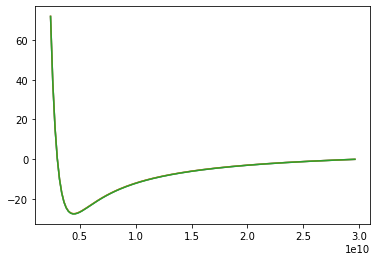

In [115]:
plt.plot(z[:-1]*10**9, calculate_force(a,k,f_0, z, simulate_df(3*10**-9, 2*10**-24,z)))
plt.plot(z[:-1]*10**9, calculate_force(a,k,f_0, z, simulate_df(3*10**-9, 2*10**-24,z)+0.015))
plt.plot(z[:-1]*10**9, calculate_force(a,k,f_0, z, simulate_df(3*10**-9, 2*10**-24,z)-0.015))

In [116]:
d_force_upper = calculate_force(a,k,f_0, z, simulate_df(3*10**-9, 2*10**-24,z)+0.015)
d_force_lower = calculate_force(a,k,f_0, z, simulate_df(3*10**-9, 2*10**-24,z)-0.015)

In [117]:
d_force = (d_force_upper - d_force_lower)/2

Text(0, 0.5, 'maximum force error (nN)')

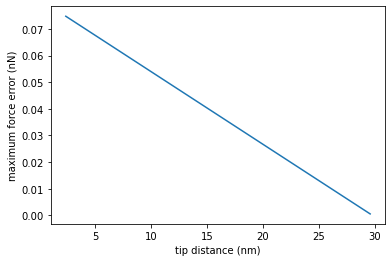

In [119]:
plt.plot(z[:-1], d_force)
plt.xlabel('tip distance (nm)')
plt.ylabel('maximum force error (nN)')